In [8]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


In [27]:
!pip install pydicom
!pip install imgaug

In [2]:
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
from keras.utils import to_categorical
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [3]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [20]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [21]:
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64)
n_ct_statistics=[]
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    for tr_idx in tr_list:
        X_i_tr_ct_list = sorted(glob.glob(path+patient_meta[tr_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
            # 전처리 --> normalize --> resize   
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
        ct_block = np.array(ct_block)
         # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[tr_idx, 0],'DX']
        dx_block = np.array(dx_block)
    
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1   # for 문 마지막 인덱스 설정
        X_i_tr_buffer = []
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
            X_p_tr.append(patient_meta[tr_idx, 0])            # 환자 번호
            X_m_tr.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보 
            maxVal = np.max(dx_block[z:z+window_size])
            Y_tr.append(maxVal)                               # DX
            
            #Y_tr.append(patient_meta[tr_idx, 1])              
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        X_i_te_ct_list = sorted(glob.glob(path+patient_meta[te_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
                ct_block.append(cv2.resize(cv2.normalize((pdc.dcmread(X_i_te_ct_list[z])).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dsize=size))
        ct_block = np.array(ct_block)
        
        # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[te_idx, 0],'DX']
        dx_block = np.array(dx_block)
  
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_meta[te_idx, 0])
            X_m_te.append(patient_meta[te_idx, 2:])

            maxVal = np.max(dx_block[z:z+window_size])
            Y_te.append(maxVal)                               # DX
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    break

(10777,) (10777, 3) (10777, 5, 64, 64) (10777,)
(2630,) (2630, 3) (2630, 5, 64, 64) (2630,)


In [22]:
# CT Length Statistics
np.mean(n_ct_statistics)

138.07

In [23]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

8749 1019 707 302
2054 352 98 126


In [24]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/'
path = './'
np.save(path+'np/X_p_tr_final', X_p_tr), np.save(path+'np/X_m_tr_final', X_m_tr), np.save(path+'np/X_i_tr_final', X_i_tr), np.save(path+'np/Y_tr_final', Y_tr)
np.save(path+'np/X_p_te_final', X_p_te), np.save(path+'np/X_m_te_final', X_m_te), np.save(path+'np/X_i_te_final', X_i_te), np.save(path+'np/Y_te_final', Y_te)

(None, None, None, None)

In [25]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(10777,) (10777, 3) (10777, 5, 64, 64) (10777,)
(2630,) (2630, 3) (2630, 5, 64, 64) (2630,)


### Augmentation 작업 전

In [26]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final.npy'), np.load(path+'X_m_tr_final.npy', allow_pickle=True), np.load(path+'X_i_tr_final.npy'), np.load(path+'Y_tr_final.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final.npy'), np.load(path+'X_m_te_final.npy', allow_pickle=True), np.load(path+'X_i_te_final.npy'), np.load(path+'Y_te_final.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(10777,) (10777, 3) (10777, 5, 64, 64) (10777,) (10777, 4)
(2630,) (2630, 3) (2630, 5, 64, 64) (2630,) (2630, 4)


In [27]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(10777, 64, 64, 5)
(2630, 64, 64, 5)


### Augmentation 작업 후

In [28]:
# Augmentations
import imgaug as ia
import imgaug.augmenters as iaa
n_aug = 2
window_size = 5
path = './np_aug_2/'
for a in range(n_aug):
    seq_pipeline = iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Fliplr(0.5)),   # horizontally flip 50% of all image 
        iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), # 0-10% 비율로 높이와 너비를 잘라준다.
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.Sometimes(0.5, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},   # x,y축 모두 80-120% 크기변환
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x,y 축모두 -20 에서 +20으로 축변환
            rotate=(-25, 25),  # -25 에서 25 도 각도 변화
            shear=(-8, 8))), # -16에서 16 기울기 변화
        iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.5))) # 이미지의 대조를 악화시키거나 개선 시킨다.
        ## 추가해 볼 기법들
        # mixup
    ], random_order=True)
    X_i_tr_aug = np.copy(X_i_tr)
    for r in range(X_i_tr_aug.shape[0]):
        buffer_block = X_i_tr_aug[r]
        for z in range(window_size):
            buffer_block[z] = seq_pipeline(images=buffer_block[z])
        X_i_tr_aug[r] = buffer_block
    X_p_tr_aug, X_m_tr_aug, Y_tr_aug = np.copy(X_p_tr), np.copy(X_m_tr), np.copy(Y_tr)
    np.save(path+'X_p_tr_aug_%02d' %(a), X_p_tr_aug), np.save(path+'X_m_tr_aug_%02d' %(a), X_m_tr_aug), np.save(path+'X_i_tr_aug_%02d' %(a), X_i_tr_aug), np.save(path+'Y_tr_aug_%02d' %(a), Y_tr_aug)

In [29]:
# Load Augmented Dataset and concat with original train Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np_aug_2/'
n_aug = 2
for a in range(n_aug):
    X_p_buffer, X_m_buffer, X_i_buffer, Y_tr_buffer = np.load(path+'X_p_tr_aug_%02d.npy' %(a)), np.load(path+'X_m_tr_aug_%02d.npy' %(a), allow_pickle=True).astype('float32'), np.load(path+'X_i_tr_aug_%02d.npy' %(a)), np.load(path+'Y_tr_aug_%02d.npy' %(a))
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.concatenate((X_p_tr, X_p_buffer), axis=0), np.concatenate((X_m_tr, X_m_buffer), axis=0), np.concatenate((X_i_tr, X_i_buffer), axis=0), np.concatenate((Y_tr, Y_tr_buffer), axis=0)
Y_tr_cat = to_categorical(Y_tr)
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(32331,) (32331, 3) (32331, 64, 64, 5) (32331,) (32331, 4)
(2630,) (2630, 3) (2630, 64, 64, 5) (2630,) (2630, 4)


### Save augmented Dataset 
- 여기서 부터 실행

In [30]:
# Save Dataset
path = './np_aug_2/'
np.save(path+'X_p_tr_final', X_p_tr), np.save(path+'X_m_tr_final', X_m_tr), np.save(path+'X_i_tr_final', X_i_tr), np.save(path+'Y_tr_final', Y_tr)
np.save(path+'X_p_te_final', X_p_te), np.save(path+'X_m_te_final', X_m_te), np.save(path+'X_i_te_final', X_i_te), np.save(path+'Y_te_final', Y_te)

(None, None, None, None)

### Load final Dataset

In [3]:
# Load Dataset
path = './np_aug_2/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final.npy'), np.load(path+'X_m_tr_final.npy', allow_pickle=True), np.load(path+'X_i_tr_final.npy'), np.load(path+'Y_tr_final.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final.npy'), np.load(path+'X_m_te_final.npy', allow_pickle=True), np.load(path+'X_i_te_final.npy'), np.load(path+'Y_te_final.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(32331,) (32331, 3) (32331, 64, 64, 5) (32331,) (32331, 4)
(2630,) (2630, 3) (2630, 64, 64, 5) (2630,) (2630, 4)


In [4]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(2, 2, 2), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)


# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()

#cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
#cnn = tf.keras.Model(cnn_input, cnn_output)
#cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#cnn.summary()

#display(Image(filename="./Kyoung/Image/cnn.png"))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 64, 5, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 64, 5, 16 144         reshape[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 32, 32, 5, 16 0           conv3d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn_meta.fit([X_i_tr,X_m_tr], Y_tr_cat, validation_data=([X_i_te,X_m_te], Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])

Epoch 1/200
1078/1078 - 13s - loss: 0.6579 - accuracy: 0.8105 - val_loss: 0.7584 - val_accuracy: 0.7810
Epoch 2/200
1078/1078 - 13s - loss: 0.3875 - accuracy: 0.8492 - val_loss: 1.0225 - val_accuracy: 0.6118
Epoch 3/200
1078/1078 - 14s - loss: 0.1437 - accuracy: 0.9530 - val_loss: 1.3702 - val_accuracy: 0.7099
Epoch 4/200
1078/1078 - 13s - loss: 0.0659 - accuracy: 0.9797 - val_loss: 1.6262 - val_accuracy: 0.6863
Epoch 5/200
1078/1078 - 13s - loss: 0.0419 - accuracy: 0.9869 - val_loss: 1.7124 - val_accuracy: 0.7217
Epoch 6/200
1078/1078 - 13s - loss: 0.0349 - accuracy: 0.9887 - val_loss: 1.7941 - val_accuracy: 0.7202
Epoch 7/200
1078/1078 - 13s - loss: 0.0313 - accuracy: 0.9906 - val_loss: 1.6801 - val_accuracy: 0.7506
Epoch 8/200
1078/1078 - 13s - loss: 0.0259 - accuracy: 0.9918 - val_loss: 1.8300 - val_accuracy: 0.7479
Epoch 9/200
1078/1078 - 13s - loss: 0.0250 - accuracy: 0.9928 - val_loss: 1.8710 - val_accuracy: 0.7179
Epoch 10/200
1078/1078 - 13s - loss: 0.0224 - accuracy: 0.9934 -

In [7]:
cnn_meta.evaluate([X_i_te,X_m_te],Y_te_cat)

83/83 [==============================] - 0s 5ms/step - loss: 2.0674 - accuracy: 0.7327


[2.0674023628234863, 0.7326996326446533]

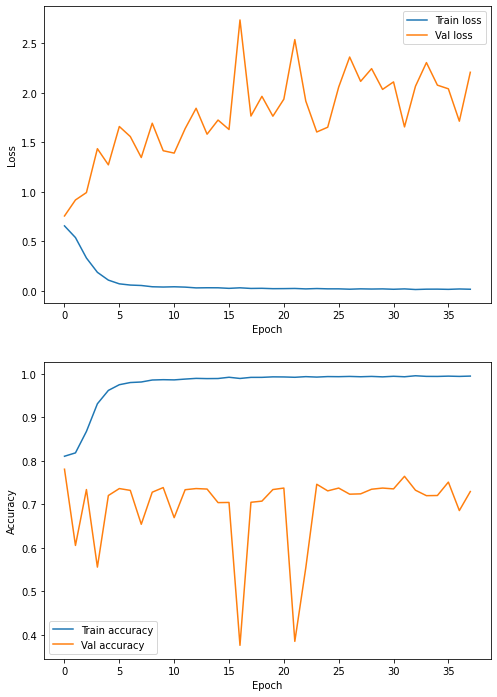

In [8]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [9]:
# save model
cnn_meta.save("./models/Dilated_3D_cnn_meta_aug.h5")

# model load하는 경우
cnn_meta  = tf.keras.models.load_model("./models/Dilated_3D_cnn_meta_aug.h5")

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [11]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'non-ROI'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [12]:
# X_train을 통한 예측값 비교
y_pred = cnn_meta.predict([X_i_tr,X_m_tr])
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 2091     0     1    29]
 [    9   891     0     6]
 [    0     0  3009    48]
 [   13     0    64 26170]]
                    precision    recall  f1-score   support

               HCC       0.99      0.99      0.99      2121
cholangiocarcinoma       1.00      0.98      0.99       906
        metastasis       0.98      0.98      0.98      3057
           non-ROI       1.00      1.00      1.00     26247

          accuracy                           0.99     32331
         macro avg       0.99      0.99      0.99     32331
      weighted avg       0.99      0.99      0.99     32331



In [13]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn_meta.predict([X_i_te,X_m_te])     
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[   4    0   10   84]
 [   5    0   10  111]
 [  40    0   50  262]
 [  68    0  113 1873]]
                    precision    recall  f1-score   support

               HCC       0.03      0.04      0.04        98
cholangiocarcinoma       0.00      0.00      0.00       126
        metastasis       0.27      0.14      0.19       352
           non-ROI       0.80      0.91      0.85      2054

          accuracy                           0.73      2630
         macro avg       0.28      0.27      0.27      2630
      weighted avg       0.67      0.73      0.69      2630



/home/super/anaconda3/envs/Kyoung/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
